In [1]:
import json
import argparse
import h5py
import numpy as np
import os
from time import time
from scipy import linalg 
import tqdm
from pathos.multiprocessing import ProcessingPool as Pool

In [13]:
def _create_dict_h5(filename):
    fid = h5py.File(filename, "r")
    d_out = {}
    for key in fid.keys():
        data = np.array(fid[key])
        nk = tuple(map(int, key[1:-1].split(',')))
        # BS: 
        # the matrix do not need be transposed in Python, 
        # But the transpose should be done in Julia.
        d_out[nk] = data # np.transpose(data)
    fid.close()
    return d_out
    
input_dir = '../example2/work_dir/dataset/processed/0'

site_positions = np.loadtxt("{}/site_positions.dat".format(input_dir))

if len(site_positions.shape) == 2:
    nsites = site_positions.shape[1]
else:
    nsites = 1
    # in case of single atom

with open("{}/orbital_types.dat".format(input_dir)) as f:
    site_norbits = np.zeros(nsites, dtype=int)
    orbital_types = []
    for index_site in range(nsites):
        orbital_type = list(map(int, f.readline().split()))
        orbital_types.append(orbital_type)
        site_norbits[index_site] = np.sum(np.array(orbital_type) * 2 + 1)
    norbits = np.sum(site_norbits)
    site_norbits_cumsum = np.cumsum(site_norbits)

rlat = np.loadtxt("{}/rlat.dat".format(input_dir)).T
# require transposition while reading rlat.dat in python

spinful = True

print("read h5")
begin_time = time()
hamiltonians_pred = _create_dict_h5(filepath)
overlaps = _create_dict_h5(filepath2)
print("Time for reading h5: ", time() - begin_time, "s")


read h5
Time for reading h5:  1.1112534999847412 s


In [31]:
H_R = {}
S_R = {}

print("construct Hamiltonian and overlap matrix in the real space")
begin_time = time()

# BS:
# this is for debug python and julia
# in julia, you can use 'sort(collect(keys(hamiltonians_pred)))'
# for key in dict(sorted(hamiltonians_pred.items())).keys():
default_dtype = np.complex128
for key in hamiltonians_pred.keys():

    hamiltonian_pred = hamiltonians_pred[key]

    if key in overlaps.keys():
        overlap = overlaps[key]
    else:
        overlap = np.zeros_like(hamiltonian_pred)
    if spinful:
        overlap = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
    R = key[:3]
    atom_i = key[3] - 1
    atom_j = key[4] - 1


    if R not in H_R.keys():
        H_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)
        S_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)

    for block_matrix_i in range(1, site_norbits[atom_i]+1):
        for block_matrix_j in range(1, site_norbits[atom_j]+1):
            index_i = site_norbits_cumsum[atom_i] - site_norbits[atom_i] + block_matrix_i - 1
            index_j = site_norbits_cumsum[atom_j] - site_norbits[atom_j] + block_matrix_j - 1
            H_R[R][index_i, index_j] = hamiltonian_pred[block_matrix_i-1, block_matrix_j-1]
            S_R[R][index_i, index_j] = overlap[block_matrix_i-1, block_matrix_j-1]


print("Time for constructing Hamiltonian and overlap matrix in the real space: ", time() - begin_time, " s")

construct Hamiltonian and overlap matrix in the real space
Time for constructing Hamiltonian and overlap matrix in the real space:  0.8138244152069092  s


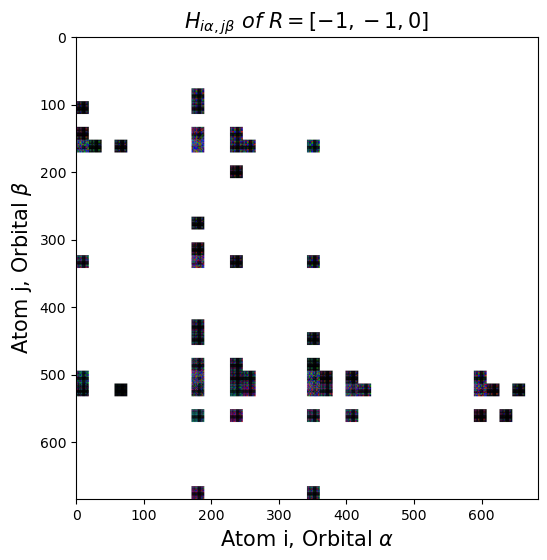

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [99]:
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z)
    h = 0.67 - 0.67 * np.sign(arg) * np.abs(arg) / np.pi  # Blue to Red
    l = np.where(r > 0, 1.0 - 1.0 / (1.0 + r**0.3), 1.0)
    # Set saturation (s) constant
    s = 0.8
    # Convert HLS to RGB
    c = np.vectorize(hls_to_rgb)(h, l, s)d04fu3
    c = np.array(c)  # Convert to array of (3, n, m) shape
    c = c.swapaxes(0, 2)  # Rearrange to (n, m, 3)
    return c

plt.figure(figsize=(8, 6))
# Plot the image
plt.xlabel('Atom i, Orbital $\\alpha$',fontsize=15)
plt.ylabel('Atom j, Orbital $\\beta$',fontsize=15)   
plt.title('$H_{i\\alpha, j\\beta}~of~R=[-1, -1, 0]$',fontsize=15)
plt.imshow(colorize(H_R[-1,-1,0]))
plt.show()


In [101]:
# calculate total k points
fermi = -3.670901903231789 / 27.21
kx = np.linspace(-0.4,0.4,5)
ky = kx
kz = 0
ky_grid,  kx_grid= np.meshgrid(kx, ky)

kx_flat = kx_grid.flatten()
ky_flat = ky_grid.flatten()
kz_flat = np.full(kx_flat.shape, kz)

# Combine into a single array
k_vec = np.vstack((kx_flat, ky_flat, kz_flat)).T
ill_project = False
ill_threshold = 5e-4
for k in range(len(k_vec)):
    H_k = np.matrix(np.zeros((norbits, norbits), dtype=default_dtype))
    S_k = np.matrix(np.zeros((norbits, norbits), dtype=default_dtype))
    for R in H_R.keys():
        H_k += H_R[R] * np.exp(1j*2*np.pi*np.dot(k_vec[k], R))
        S_k += S_R[R] * np.exp(1j*2*np.pi*np.dot(k_vec[k], R))
        # print(H_k)
    H_k = (H_k + H_k.getH())/2.
    S_k = (S_k + S_k.getH())/2.
    num_projected_out = 0
    if ill_project:
        egval_S, egvec_S = linalg.eig(S_k)
        project_index = np.argwhere(abs(egval_S)> ill_threshold)
        if len(project_index) != norbits:
            egvec_S = np.matrix(egvec_S[:, project_index])
            num_projected_out = norbits - len(project_index)
            H_k = egvec_S.H @ H_k @ egvec_S
            S_k = egvec_S.H @ S_k @ egvec_S
            egval = linalg.eigvalsh(H_k, S_k, lower=False)
            egval = np.concatenate([egval, np.full(num_projected_out, 1e4)])
        else:
            # egval = linalg.eigvalsh(H_k, S_k, lower=False)
            egval, egvec = linalg.eigh(H_k, S_k, lower=False)
    else:
        #---------------------------------------------
        # BS: only eigenvalues are needed in this part, 
        # the upper matrix is used
        # egval = linalg.eigvalsh(H_k, S_k, lower=False) 
        egval, egvec = linalg.eigh(H_k, S_k, lower=False)


    print( {"k_point":k_vec[k], "egval": ((egval[0]))/27.21 , "num_projected_out":num_projected_out})

{'k_point': array([-0.4, -0.4,  0. ]), 'egval': -1.013044105167608, 'num_projected_out': 0}
{'k_point': array([-0.4, -0.2,  0. ]), 'egval': -1.01304285186364, 'num_projected_out': 0}
{'k_point': array([-0.4,  0. ,  0. ]), 'egval': -1.0130450946235676, 'num_projected_out': 0}
{'k_point': array([-0.4,  0.2,  0. ]), 'egval': -1.0130475821427405, 'num_projected_out': 0}
{'k_point': array([-0.4,  0.4,  0. ]), 'egval': -1.0130470448058875, 'num_projected_out': 0}
{'k_point': array([-0.2, -0.4,  0. ]), 'egval': -1.013041372879531, 'num_projected_out': 0}
{'k_point': array([-0.2, -0.2,  0. ]), 'egval': -1.0130444714532914, 'num_projected_out': 0}
{'k_point': array([-0.2,  0. ,  0. ]), 'egval': -1.0130510626415985, 'num_projected_out': 0}
{'k_point': array([-0.2,  0.2,  0. ]), 'egval': -1.013052121467392, 'num_projected_out': 0}
{'k_point': array([-0.2,  0.4,  0. ]), 'egval': -1.0130463205858264, 'num_projected_out': 0}
{'k_point': array([ 0. , -0.4,  0. ]), 'egval': -1.0130420553282555, 'num_p

In [85]:
fermi / 27.21

-0.13491002951972764

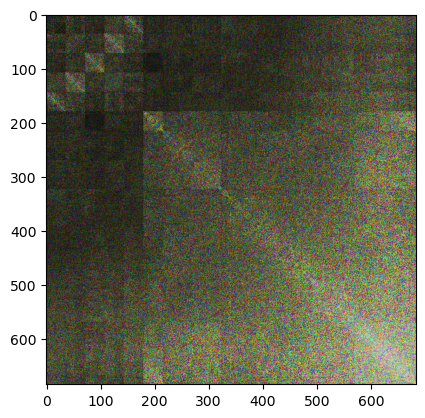

In [106]:
plt.imshow(colorize(egvec.T @ egvec))
plt.show()